In [1]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from os.path import join
from keras.losses import binary_crossentropy
import keras.backend as K
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from skimage.io import imread
import tensorflow as tf
from IPython.display import clear_output

Using TensorFlow backend.


In [2]:
DATA_PATH   = '../input/airbus-ship-detection/'
TRAIN_PATH  = DATA_PATH+'train_v2/'
TEST_PATH   = DATA_PATH+'test_v2/' 
IMG_SIZE    = (768, 768)
INPUT_SHAPE = (768, 768)
TARGET_SIZE = (256, 256)
BATCH_SIZE  = 48
EPOCHS      = 80

In [3]:
train_df = pd.read_csv('../input/airbusshipbalance/train_df.csv')
valid_df = pd.read_csv('../input/airbusshipbalance/valid_df.csv')

In [4]:
def get_mask_with_image(ImageId, masks_df):
    image = imread(join(TRAIN_PATH, ImageId))
    image = image[::3,::3]
    mask  = masks_as_image(masks_df['EncodedPixels'].values)
    mask  = np.expand_dims(mask, -1)
    mask  = mask[::3,::3]
    return [image],[mask]

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

def rle_decode(mask_rle, shape=INPUT_SHAPE):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]

    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


In [5]:
def make_image_gen(in_df, batch_size=BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    masks = []
    images = []
    while True:
        np.random.shuffle(all_batches)
        for image, masks_df in all_batches:
            image, mask = get_mask_with_image(image, masks_df)            
            images += image
            masks += mask
            if len(images)>=batch_size:
                yield np.stack(images, 0)/255.0, np.stack(masks, 0)
                masks, images=[], []

In [6]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss
def get_unet_model(input_shape=(256, 256, 3), num_classes=1):

    def fire(x, filters, kernel_size):
        y1 = Conv2D(filters, kernel_size, activation='relu', padding='same')(x)
        y2 = Conv2D(filters, kernel_size, activation='relu', padding='same')(y1)
        y3 = BatchNormalization(momentum=0.9)(y2)     
        return y3

    def fire_module(filters, kernel_size):
        return lambda x: fire(x, filters, kernel_size)

    def fire_up(x, filters, kernel_size, concat_layer):
        y1 = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
        y2 = concatenate([y1, concat_layer])
        y3 = fire_module(filters, kernel_size)(y2)
        return y3

    def up_fire_module(filters, kernel_size, concat_layer):
        return lambda x: fire_up(x, filters, kernel_size, concat_layer)

    input_img = Input(shape=input_shape) #256

    down1 = fire_module(8, (3, 3))(input_img)
    pool1 = MaxPooling2D((2, 2))(down1)  #128

    down2 = fire_module(16, (3, 3))(pool1)
    pool2 = MaxPooling2D((2, 2))(down2) #64
    
    down3 = fire_module(32, (3, 3))(pool2)
    pool3 = MaxPooling2D((2, 2))(down3) #32
    
    down4 = fire_module(64, (3, 3))(pool3)
    pool4 = MaxPooling2D((2, 2))(down4) #16
    
    down5 = fire_module(128, (3, 3))(pool4)
    pool5 = MaxPooling2D((2, 2))(down5) # 8
    
    down6 = fire_module(256, (3, 3))(pool5) #center
    
    up6 = up_fire_module(128, (3, 3), down5)(down6) #16
    up7 = up_fire_module(64, (3, 3), down4)(up6) #32
    up8 = up_fire_module(32, (3, 3), down3)(up7) #64
    up9 = up_fire_module(16, (3, 3), down2)(up8) #128
    up10 = up_fire_module(8, (3, 3), down1)(up9) #256
    
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(up10) 

    model = Model(inputs=[input_img], outputs=[outputs])
    model.compile(loss=bce_dice_loss, metrics=[dice_coeff], optimizer='adam')
    return model

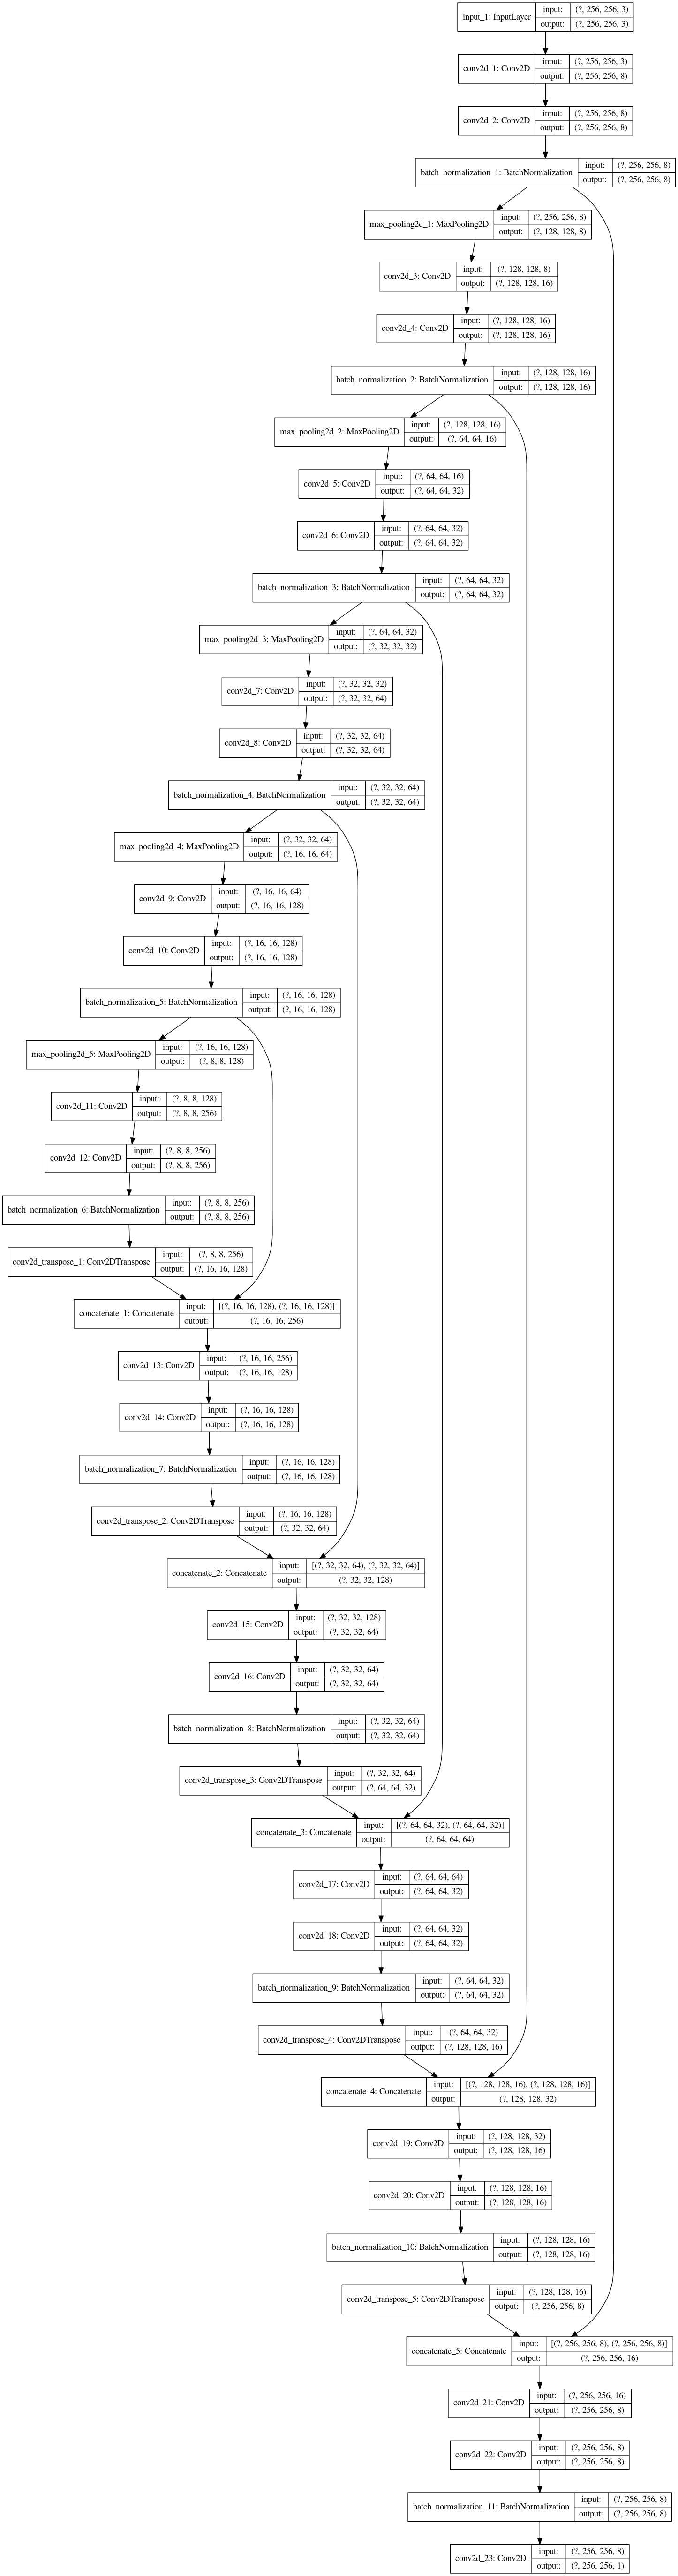

In [7]:
model = get_unet_model()
# model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [8]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, TensorBoard
weight_path="{}_weights.best.hdf5".format('model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)

def lr_decay(epoch):
  return 0.1 * math.pow(0.766, epoch)

callback_learning_rate = LearningRateScheduler(lr_decay, verbose=1)

class EarlyStop(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_loss')<0.05):
      print("\nReached 005%% value losse so cancelling training!")
      self.model.stop_training = True
        
early_stop = EarlyStop()  

class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        self.val_accuracy = []
        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('dice_coeff'))
        self.val_accuracy.append(logs.get('val_dice_coeff'))
        self.i += 1

        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        ax1.plot(self.x, self.accuracy, 'r', label="dice_coeff")
        ax1.plot(self.x, self.val_accuracy, 'bo', label="val_dice_coeff")
        ax1.set_title('Model accuracy')
        ax1.set_ylabel('Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylim([0, 1])
        ax1.legend(['Train', 'Test'], loc='upper left')
         
        ax2.plot(self.x, self.losses, 'r', label="loss")
        ax2.plot(self.x, self.val_losses,'bo', label="val_loss")
        ax2.set_title('Model loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylim([0, 1])
        ax2.legend(['Train', 'Test'], loc='upper left')
        plt.show()

        print(logs)
plot_losses = PlotLosses()

# tensorboard_log = TensorBoard(log_dir="./logs")  callback_learning_rate,

callbacks_list = [checkpoint, plot_losses]

In [9]:
train_gen = make_image_gen(train_df)
valid_x, valid_y = next(make_image_gen(valid_df))

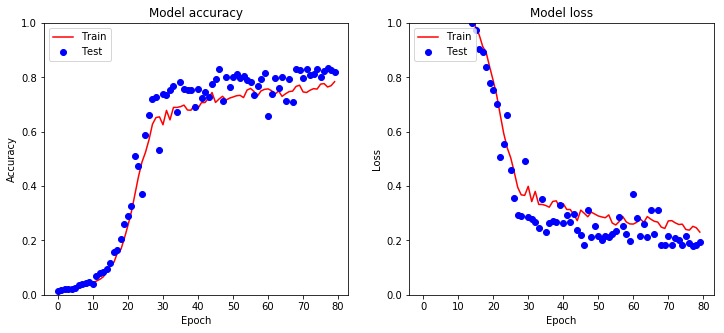

{'val_loss': 0.19360212981700897, 'val_dice_coeff': 0.8206369280815125, 'loss': 0.23075977087020874, 'dice_coeff': 0.78418887}


In [10]:
step_per_epoch = 25
history = model.fit_generator(train_gen,
                             steps_per_epoch=step_per_epoch,
                             epochs=EPOCHS,
                             validation_data=(valid_x, valid_y),
                             callbacks=callbacks_list)

In [11]:
accuracy = history.history['dice_coeff']
loss = history.history['loss']
val_accuracy = history.history['val_dice_coeff']
val_loss = history.history['val_loss']

print(f'Training Accuracy: {np.max(accuracy)}')
print(f'Training Loss: {np.min(loss)}')
print(f'Validation Accuracy: {np.max(val_accuracy)}')
print(f'Validation Loss: {np.min(val_loss)}')

Training Accuracy: 0.7841888666152954
Training Loss: 0.23075977087020874
Validation Accuracy: 0.8338665962219238
Validation Loss: 0.1786547154188156


In [12]:
model.load_weights(weight_path)
model.save('model_dice_coeff_with_binary_cross_loss.h5')